In [1]:
'''
Nicole Osayande
261042925
Bzdok Lab MILA
'''
import os
import aesara
import scipy as sp
import arviz as az
import numpy as np
import pymc3 as pm
import pandas as pd
import xarray as xr
import seaborn as sns
from theano import shared
import arviz.labels as azl
from scipy.stats import zscore
from theano import tensor as tt
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

In [2]:
#investigating: overall cognition and parental education level
data = pd.read_csv('/Users/nicoleosa/Documents/ABCD_data/abcd_nda3_manuscript.csv', usecols=['nihtbx_totalcomp_uncorrected','reshist_addr1_adi_edu_high','abcd_site','site_id_l','race_ethnicity'], index_col=False)
print(data.shape)

(10843, 5)


In [3]:
val=data['reshist_addr1_adi_edu_high'].median()
data.loc[data['reshist_addr1_adi_edu_high'] <= val, 'reshist_addr1_adi_edu_high_bin'] = 0
data.loc[data['reshist_addr1_adi_edu_high'] > val, 'reshist_addr1_adi_edu_high_bin'] = 1

In [4]:
data['nihtbx_totalcomp_uncorrected_log']= np.log(data['nihtbx_totalcomp_uncorrected'])
col='nihtbx_totalcomp_uncorrected_log'
data['nihtbx_totalcomp_uncorrected_zscore'] = (data[col] - data[col].mean())/data[col].std(ddof=0)

In [5]:
race_idxs, race = pd.factorize(data.race_ethnicity)
data['race_enc'] = race_idxs #for shared object

state_idxs, state = pd.factorize(data.site_id_l)
data['state_enc'] = state_idxs #for shared object

In [7]:
#get input variables for shared object
abcd_race = data.race_enc.values
abcd_state = data.state_enc.values
edu = data.reshist_addr1_adi_edu_high_bin.values
target_values = data.nihtbx_totalcomp_uncorrected_zscore.values

In [8]:
#initialize shared objects for the model hierarchies and input variable 
abcd_race_ = shared(abcd_race)
abcd_state_ = shared(abcd_state)
edu_ = shared(edu)

In [9]:
#varying intercepts and varying slopes: 
#predicting overall cognition scores from census education level 

RANDOM_SEED = 8924
np.random.seed(286)

coords = {"abcd_race": np.arange(len(race)),"abcd_state": np.arange(len(state))}


with pm.Model(coords=coords) as varying_intercept_slope:
    
    # Hyperparameters
    a = pm.Normal("a", mu=0.0, sigma=5.0)
    sigma_a = pm.Exponential("sigma_a", 1.0)
    b = pm.Normal("b", mu=0.0, sigma=1.0)
    sigma_b = pm.Exponential("sigma_b", 0.5) 
   
    # Varying intercepts
    a_state = pm.Normal("a_state", mu=0.0, sigma=1.0, dims ='abcd_state')

    # Varying slopes
    b_race = pm.Normal("b_race", mu=0.0, sigma=1.0, dims ='abcd_race')
    

    # Expected value per state, theta
    # Non-centered reparameterization 
    theta = (a + a_state[abcd_state_] * sigma_a) + (b + b_race[abcd_race_] * sigma_b) * edu_
    
    # Model error:
    sigma = pm.Exponential("sigma", 1.0)

    likelihood = pm.Normal("likelihood", theta, sigma=sigma, observed=target_values)
    
with varying_intercept_slope:
    varying_intercept_slope_idata = pm.sample(2000,
        tune=3000, init="adapt_diag", target_accept=0.99, random_seed=RANDOM_SEED, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b_race, a_state, sigma_b, b, sigma_a, a]


Sampling 4 chains for 3_000 tune and 2_000 draw iterations (12_000 + 8_000 draws total) took 681 seconds.
The number of effective samples is smaller than 25% for some parameters.


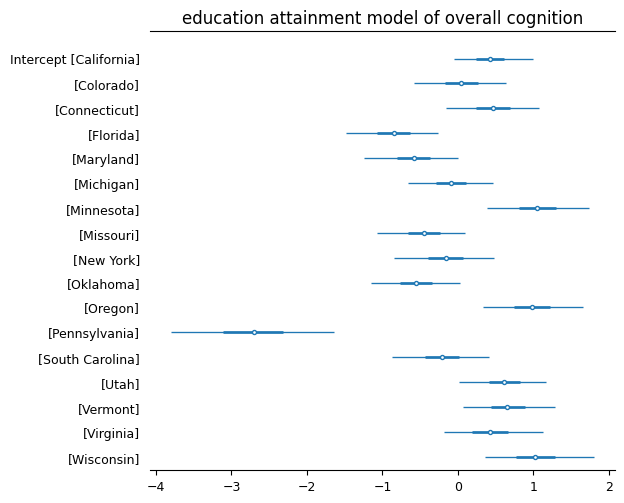

In [10]:
coords = {"abcd_state": [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]}
var_names = ["a_state"]
# Define the var_name_map and coord_map for custom labels
var_name_map = {"a_state": "Intercept "}
coord_map = {"abcd_state": { 0:'California', 1:'Colorado', 2:'Connecticut', 3:'Florida', 4:'Maryland',
       5:'Michigan', 6:'Minnesota', 7:'Missouri', 8:'New York', 9:'Oklahoma', 10:'Oregon',
       11:'Pennsylvania', 12:'South Carolina', 13:'Utah', 14:'Vermont', 15:'Virginia',
       16:'Wisconsin'}}

# Create the MapLabeller object
labeller = azl.MapLabeller(var_name_map=var_name_map, coord_map=coord_map)

axes= az.plot_forest(varying_intercept_slope_idata, var_names=var_names,coords=coords,labeller=labeller,combined=True, textsize=9);
fig = axes.ravel()[0].figure
plt.title("education attainment model of overall cognition")
#ax.set_xticklabels(['-4','-2','0','2','4'],size=28)
#fig.set_yticklabels(['','-3','-2','-1','0','1','2','3'],size=28)
#fig.savefig('forest_plot_state_intercept_edu_overall_cognition_results_f3.svg',transparent=True,dpi=600,format='svg')

/var/folders/vm/f5ddqzq57cnd0dhfcyvb42440000gn/T/ipykernel_57921/435194367.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


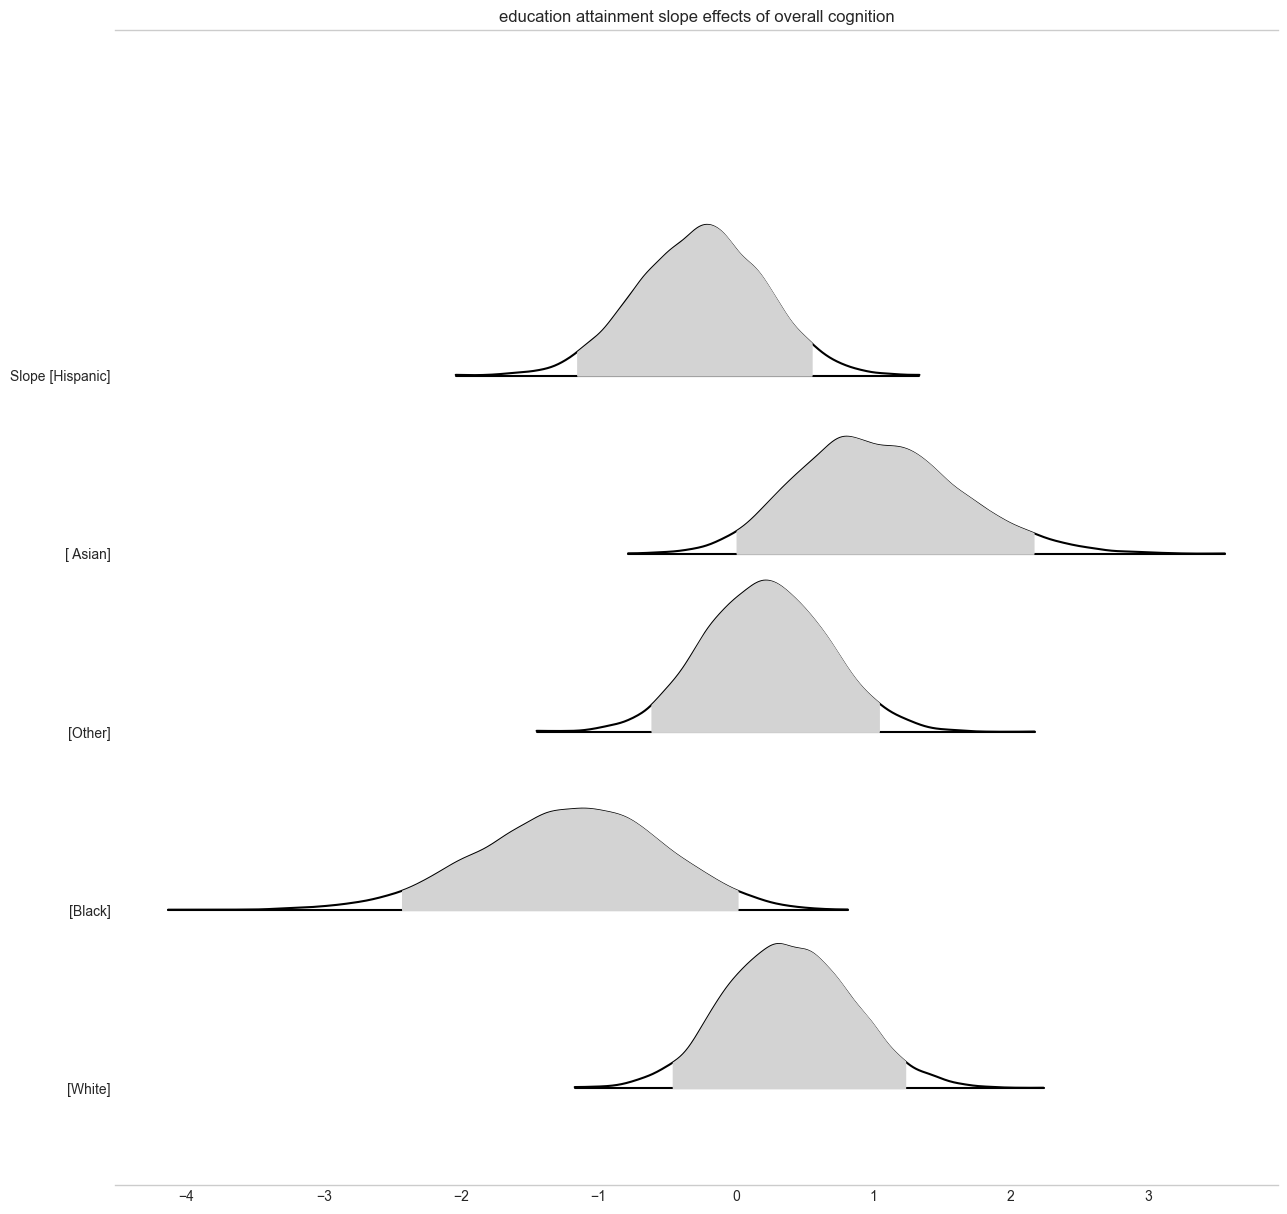

In [11]:
plt.style.use('seaborn-whitegrid')
coords = {"abcd_race": [0,1,2,3,4]}
var_names = ["b_race"]
# Define the var_name_map and coord_map for custom labels
var_name_map = {"b_race": "Slope "}
coord_map = {"abcd_race": { 0:"Hispanic", 1: " Asian", 2:"Other", 3:"Black", 4:"White"}}

# Create the MapLabeller object
labeller = azl.MapLabeller(var_name_map=var_name_map, coord_map=coord_map)

axes = az.plot_forest(varying_intercept_slope_idata,
                           kind='ridgeplot',var_names=var_names,coords=coords,labeller=labeller,
                           combined=True,
                           ridgeplot_truncate=False,
                           ridgeplot_overlap=0.7,
                           colors='lightgrey',
                           figsize=(15, 15))
fig = axes.ravel()[0].figure
plt.title("education attainment slope effects of overall cognition")
#ax.set_xticklabels(['-4','-2','0','2','4'],size=28)
#fig.set_yticklabels(['','-3','-2','-1','0','1','2','3'],size=28)
#fig.savefig('forest_ridge_plot_race_slope_edu_overall_cognition_results_f3.svg',transparent=True,dpi=600,format='svg')

In [12]:
with varying_intercept_slope:
    ppc = pm.sample_posterior_predictive(varying_intercept_slope_idata, var_names=["likelihood","a_state","b_race"], random_seed=RANDOM_SEED)
    

In [13]:
# Bayesian R2 score 
az.r2_score(target_values, ppc['likelihood'])

r2        0.360977
r2_std    0.003459
dtype: float64

In [14]:
#create ppc dataframe 
PP_COL = ['pp_cog_{}'.format(i) for i in range(ppc['likelihood'].shape[0])]
ppc_df = pd.DataFrame(ppc['likelihood'].T, columns=PP_COL)
ppc_df.shape

(10843, 8000)

In [15]:
# get race, state and parental education attain columns for ppc dataframe, reset index for merging dataframes
abcd_race_df = pd.DataFrame(data['race_ethnicity'],columns =['race_ethnicity']).reset_index(drop=True)
abcd_state_df = pd.DataFrame(data['site_id_l'],columns =['site_id_l']).reset_index(drop=True)
abcd_edu_df = pd.DataFrame(data['reshist_addr1_adi_edu_high_bin'],columns =['reshist_addr1_adi_edu_high_bin']).reset_index(drop=True)


In [16]:
ppc_df = pd.merge(abcd_race_df,ppc_df,left_index=True, right_index=True)
ppc_df = pd.merge(abcd_state_df,ppc_df,left_index=True, right_index=True)
ppc_df = pd.merge(abcd_edu_df,ppc_df,left_index=True, right_index=True)


In [17]:
ppc_edu_race_mean = (ppc_df.groupby(['reshist_addr1_adi_edu_high_bin','race_ethnicity']).apply(lambda df: df[PP_COL].mean(axis=0)))
ppc_edu_race_mean

pp_cog_0  pp_cog_1  pp_cog_2  \
reshist_addr1_adi_edu_high_bin race_ethnicity                                 
0.0                            Asian          -0.247443 -0.026035 -0.249746   
                               Black          -0.283388 -0.303794 -0.400567   
                               Hispanic       -0.217209 -0.250608 -0.278229   
                               Other          -0.226374 -0.326974 -0.320725   
                               White          -0.222078 -0.234083 -0.269833   
1.0                            Asian           0.540965  0.747750  0.482121   
                               Black          -0.363807 -0.510498 -0.342723   
                               Hispanic        0.018173 -0.013877 -0.010935   
                               Other           0.199121  0.201835  0.140228   
                               White           0.378960  0.343046  0.362200   

                                               pp_cog_3  pp_cog_4  pp_cog_5  \
reshist_addr1_adi_edu_high_bin race_ethnicity                                 
0.0                            Asian          -0.090098 -0.310418 -0.389451   
                               Black          -0.319324 -0.375697 -0.349708   
                               Hispanic       -0.180483 -0.245120 -0.234453   
                               Other          -0.238561 -0.282565 -0.251367   
                               White          -0.203962 -0.240241 -0.205667   
1.0                            Asian           0.522468  0.630514  0.571826   
                               Black          -0.407068 -0.400430 -0.365411   
                               Hispanic        0.038868  0.087418 -0.072410   
                               Other           0.195618  0.187529  0.172790   
                               White           0.347640  0.381146  0.318215   

                                               pp_cog_6  pp_cog_7  pp_cog_8  \
reshist_addr1_adi_edu_high_bin race_ethnicity                                 
0.0                            Asian          -0.194549 -0.146966 -0.222449   
                               Black          -0.395247 -0.353570 -0.322524   
                               Hispanic       -0.246256 -0.236584 -0.237516   
                               Other          -0.221458 -0.338103 -0.272936   
                               White          -0.206685 -0.203056 -0.194905   
1.0                            Asian           0.434463  0.549994  0.601469   
                               Black          -0.373840 -0.493345 -0.505143   
                               Hispanic        0.102903  0.033087  0.132883   
                               Other           0.102617  0.160610  0.239258   
                               White           0.310983  0.347197  0.310663   

                                               pp_cog_9  ...  pp_cog_7990  \
reshist_addr1_adi_edu_high_bin race_ethnicity            ...                
0.0                            Asian          -0.125764  ...    -0.291083   
                               Black          -0.343825  ...    -0.340775   
                               Hispanic       -0.215180  ...    -0.233809   
                               Other          -0.339149  ...    -0.248518   
                               White          -0.230867  ...    -0.219626   
1.0                            Asian           0.630464  ...     0.445146   
                               Black          -0.402661  ...    -0.521414   
                               Hispanic        0.143215  ...     0.034747   
                               Other           0.201344  ...     0.272371   
                               White           0.344450  ...     0.357295   

                                               pp_cog_7991  pp_cog_7992  \
reshist_addr1_adi_edu_high_bin race_ethnicity                             
0.0                            Asian             -0.133473    -0.208414   
                               Black             -

In [18]:
ppc_edu_race_mean_summ=ppc_edu_race_mean.mean(axis=1)
ppc_edu_race_mean_summ

reshist_addr1_adi_edu_high_bin  race_ethnicity
0.0                             Asian            -0.180728
                                Black            -0.356905
                                Hispanic         -0.239436
                                Other            -0.276746
                                White            -0.229385
1.0                             Asian             0.635766
                                Black            -0.447872
                                Hispanic          0.040329
                                Other             0.237519
                                White             0.344720
dtype: float64

In [19]:
ppc_race_mean = (ppc_df.groupby(['race_ethnicity']).apply(lambda df: df[PP_COL].mean(axis=0)))
ppc_race_mean

,pp_cog_0,pp_cog_1,pp_cog_2,pp_cog_3,pp_cog_4,pp_cog_5,pp_cog_6,pp_cog_7,pp_cog_8,pp_cog_9,...,pp_cog_7990,pp_cog_7991,pp_cog_7992,pp_cog_7993,pp_cog_7994,pp_cog_7995,pp_cog_7996,pp_cog_7997,pp_cog_7998,pp_cog_7999
race_ethnicity,,,,,,,,,,,,,,,,,,,,,
Asian,0.261529,0.473497,0.222725,0.305356,0.297019,0.231120,0.211522,0.302970,0.309448,0.362434,...,0.184204,0.199209,0.424546,0.267454,0.297050,0.574314,0.452085,0.326808,0.285946,0.241386
Black,-0.299820,-0.346028,-0.388748,-0.337252,-0.380750,-0.352917,-0.390873,-0.382129,-0.359837,-0.355847,...,-0.377683,-0.419649,-0.403870,-0.365237,-0.373747,-0.433524,-0.362667,-0.388126,-0.335243,-0.410755
Hispanic,-0.160170,-0.193241,-0.213456,-0.127328,-0.164537,-0.195186,-0.161645,-0.171235,-0.147759,-0.128331,...,-0.168731,-0.104193,-0.157809,-0.143260,-0.120328,-0.184383,-0.171445,-0.143405,-0.173783,-0.179635
Other,-0.005538,-0.052517,-0.081486,-0.013218,-0.038582,-0.031226,-0.053260,-0.079266,-0.007103,-0.058628,...,0.021828,-0.001196,-0.024746,-0.019701,0.006473,-0.008856,0.016850,-0.082801,-0.073824,-0.001618
White,0.177224,0.149335,0.150061,0.162497,0.172580,0.142376,0.137230,0.162507,0.140971,0.151347,...,0.163654,0.116902,0.139637,0.143903,0.135587,0.107554,0.129423,0.165465,0.159426,0.171851


In [20]:
ppc_race_mean_summ = ppc_race_mean.mean(axis=1)

In [21]:
ppc_edu_state_mean = (ppc_df.groupby(['reshist_addr1_adi_edu_high_bin','site_id_l']).apply(lambda df: df[PP_COL].mean(axis=0)))
ppc_edu_state_mean_summ = ppc_edu_state_mean.mean(axis=1)


In [22]:
ppc_state_mean = (ppc_df.groupby(['site_id_l']).apply(lambda df: df[PP_COL].mean(axis=0)))
ppc_state_mean_summ = ppc_state_mean.mean(axis=1) #for the geomaps


In [23]:
ppc_edu_state_mean_summ_list=ppc_edu_state_mean_summ.to_numpy()
low_edu_state = ppc_edu_state_mean_summ_list[:17]
high_edu_state = ppc_edu_state_mean_summ_list[-17:]

In [24]:
mean_predictions_state = [low_edu_state,high_edu_state] 
  
# Create the pandas DataFrame 
mean_pred_state = pd.DataFrame(mean_predictions_state, columns=state) 
  
# print dataframe. 
mean_pred_state

,california,colorado,connecticut,florida,maryland,michigan,minnesota,missouri,newyork,oklahoma,oregon,pennsylvania,southcarolina,utah,vermont,virginia,wisconsin
0,-0.160149,-0.232632,-0.151491,-0.400694,-0.350865,-0.257622,-0.043147,-0.326364,-0.271657,-0.345884,-0.055595,-0.751626,-0.283014,-0.125586,-0.119271,-0.159469,-0.045807
1,0.323336,0.251242,0.309076,-0.012853,0.069270,0.172675,0.435345,0.051888,0.222080,0.114722,0.432554,-0.359097,0.158180,0.377286,0.408705,0.271522,0.440752


In [25]:
ppc_edu_race_mean_summ_list=ppc_edu_race_mean_summ.to_numpy()
low_edu_race = ppc_edu_race_mean_summ_list[:5]
high_edu_race = ppc_edu_race_mean_summ_list[-5:]

In [26]:
# initialize list of lists 
mean_predictions_race = [low_edu_race,high_edu_race] 
  
# Create the pandas DataFrame 
mean_pred_race = pd.DataFrame(mean_predictions_race, columns=["Asian","Black","Hispanic","Other","White"]) 
  
# print dataframe. 
mean_pred_race

,Asian,Black,Hispanic,Other,White
0,-0.180728,-0.356905,-0.239436,-0.276746,-0.229385
1,0.635766,-0.447872,0.040329,0.237519,0.344720


In [27]:
#auxiliary data
census_data = pd.read_csv('/Users/nicoleosa/Documents/ABCD_data/census_poststrat_dataset.csv', usecols=['state','Education_LT12years_score','County_population','race_ethnicity'], index_col=False)
print(census_data.shape)

(1042, 4)


In [28]:
val = census_data['Education_LT12years_score'].median()
census_data.loc[census_data['Education_LT12years_score'] < val, 'Education_LT12years_score_bin'] = 0
census_data.loc[census_data['Education_LT12years_score'] >= val, 'Education_LT12years_score_bin'] = 1

In [29]:
census = (census_data.groupby(['state','race_ethnicity','Education_LT12years_score_bin']).County_population.agg(['sum']).reset_index())
census = census.rename(columns={'sum': 'freq'})
census

,state,race_ethnicity,Education_LT12years_score_bin,freq
0,california,Asian,0.0,947674
1,california,Asian,1.0,887641
2,california,Black,0.0,17420
3,california,Black,1.0,3937055
4,california,Hispanic,0.0,774189
...,...,...,...,...
131,wisconsin,Black,1.0,53760
132,wisconsin,Hispanic,0.0,88054
133,wisconsin,Other,0.0,183517
134,wisconsin,White,0.0,4111680


In [30]:
census['race_enc']=census['race_ethnicity']
census['race_enc'].replace(race,[0,1,2,3,4], inplace=True)
census['state_enc']=census['state']
census['state_enc'].replace(state,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16], inplace=True)
census.head()

,state,race_ethnicity,Education_LT12years_score_bin,freq,race_enc,state_enc
0,california,Asian,0.0,947674,1,0
1,california,Asian,1.0,887641,1,0
2,california,Black,0.0,17420,3,0
3,california,Black,1.0,3937055,3,0
4,california,Hispanic,0.0,774189,0,0


In [31]:
#fix theano shared tensor type error
census=census.astype({'Education_LT12years_score_bin':'uint8'})

In [32]:
#initialize poststrat vars
ps_abcd_race = census.race_enc.values
ps_abcd_state = census.state_enc.values
ps_edu = census.Education_LT12years_score_bin.values

#swap the model input variables 
abcd_race_.set_value(ps_abcd_race)
abcd_state_.set_value(ps_abcd_state)
edu_.set_value(ps_edu)

In [33]:
#re-run posterior predictive check with auxiliary census SDI data
with varying_intercept_slope:
    ppc2 = pm.sample_posterior_predictive(varying_intercept_slope_idata,var_names=['likelihood','a_state','b_race'],random_seed=RANDOM_SEED)
    

In [34]:
#create ppc dataframe 
PP_COL2 = ['pp_cog_{}'.format(i) for i in range(ppc2['likelihood'].shape[0])]
ppc_df2 = pd.DataFrame(ppc2['likelihood'].T, columns=PP_COL2)
ppc_df2.shape


(136, 8000)

In [35]:
censust=census
censust

,state,race_ethnicity,Education_LT12years_score_bin,freq,race_enc,state_enc
0,california,Asian,0,947674,1,0
1,california,Asian,1,887641,1,0
2,california,Black,0,17420,3,0
3,california,Black,1,3937055,3,0
4,california,Hispanic,0,774189,0,0
...,...,...,...,...,...,...
131,wisconsin,Black,1,53760,3,16
132,wisconsin,Hispanic,0,88054,0,16
133,wisconsin,Other,0,183517,2,16
134,wisconsin,White,0,4111680,4,16


In [36]:
# get race, state, and parental education attainment columns for ppc dataframe, reset index for merging dataframes
abcd_race_df2 = pd.DataFrame(censust['race_ethnicity'],columns =['race_ethnicity']).reset_index(drop=True)
abcd_state_df2 = pd.DataFrame(censust['state'],columns =['state']).reset_index(drop=True)
abcd_edu_df2 = pd.DataFrame(censust['Education_LT12years_score_bin'],columns =['Education_LT12years_score_bin']).reset_index(drop=True)


In [37]:
ppc_df2 = pd.merge(censust['freq'],ppc_df2,left_index=True, right_index=True)
ppc_df2 = pd.merge(abcd_edu_df2,ppc_df2,left_index=True, right_index=True)
ppc_df2 = pd.merge(abcd_race_df2,ppc_df2,left_index=True, right_index=True)
ppc_df2 = pd.merge(abcd_state_df2,ppc_df2,left_index=True, right_index=True)
ppc_df2

,state,race_ethnicity,Education_LT12years_score_bin,freq,pp_cog_0,pp_cog_1,pp_cog_2,pp_cog_3,pp_cog_4,pp_cog_5,...,pp_cog_7990,pp_cog_7991,pp_cog_7992,pp_cog_7993,pp_cog_7994,pp_cog_7995,pp_cog_7996,pp_cog_7997,pp_cog_7998,pp_cog_7999
0,california,Asian,0,947674,-1.556741,-0.094708,-1.486415,0.751388,-1.500102,-0.001312,...,-0.566506,-1.513406,-0.883337,0.458051,0.058931,-0.439141,-0.152669,-0.057482,-0.550129,0.318997
1,california,Asian,1,887641,-0.262288,0.745847,0.559522,-0.229542,0.116171,-0.026328,...,0.198351,0.525544,0.647086,1.104746,-0.023891,1.797407,-0.286888,0.390939,-0.184150,-0.028677
2,california,Black,0,17420,0.527538,0.113324,-0.288659,0.280343,1.124881,-1.144171,...,0.429586,-0.122389,0.611592,-0.557314,1.582755,-0.098098,0.685576,-0.367245,-1.035928,-1.459245
3,california,Black,1,3937055,-0.503140,0.266874,0.278340,1.090772,1.748642,-0.938869,...,1.909280,-0.753314,-0.361559,-1.534730,-0.155331,-1.626349,-0.383311,-0.340219,-2.134691,-0.084293
4,california,Hispanic,0,774189,-1.313022,0.266412,-0.722264,0.451436,-2.318135,1.460193,...,-1.104871,0.822305,-0.851120,0.125936,0.202499,-0.636799,-1.711072,1.517751,-0.627698,0.142818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,wisconsin,Black,1,53760,0.683064,0.657213,-0.778846,-0.357251,-0.163311,-0.632342,...,0.740124,-0.543103,-0.262943,-0.688583,-1.481235,-0.937223,0.138887,-0.374226,0.410211,0.008037
132,wisconsin,Hispanic,0,88054,0.804806,-1.010505,-0.573353,-0.778471,-0.592635,0.734172,...,-0.901681,1.372996,-1.473681,0.421963,0.540606,-0.355255,0.455776,-0.398433,-1.023941,0.565882
133,wisconsin,Other,0,183517,-0.709464,-0.850924,-0.232710,-0.742025,-0.703902,0.342295,...,-0.373560,0.025836,-0.455969,-1.519963,0.777215,-0.842774,-2.005848,-1.268576,0.139944,-0.972025
134,wisconsin,White,0,4111680,-1.184284,0.966090,1.015690,1.417154,0.063722,-0.970581,...,-1.584383,-0.533481,0.534469,-0.078725,-0.823227,0.396800,-1.378553,0.575930,-2.225427,1.251207


In [38]:
#data-weighted for each category
ppc_poststrat_df = ppc_df2.groupby(['state','race_ethnicity','Education_LT12years_score_bin']).apply(lambda df: (df[PP_COL2]*df.freq.sum(axis=0)))
ppc_poststrat_df

pp_cog_0  \
state      race_ethnicity Education_LT12years_score_bin                     
california Asian          0                             0   -1.475283e+06   
                          1                             1   -2.328172e+05   
           Black          0                             2    9.189721e+03   
                          1                             3   -1.980891e+06   
           Hispanic       0                             4   -1.016527e+06   
...                                                                   ...   
wisconsin  Black          1                             131  3.672150e+04   
           Hispanic       0                             132  7.086636e+04   
           Other          0                             133 -1.301987e+05   
           White          0                             134 -4.869395e+06   
                          1                             135  3.080219e+04   

                                                                 pp_cog_1  \
state      race_ethnicity Education_LT12years_score_bin                     
california Asian          0                             0   -8.975267e+04   
                          1                             1    6.620440e+05   
           Black          0                             2    1.974103e+03   
                          1                             3    1.050699e+06   
           Hispanic       0                             4    2.062536e+05   
...                                                                   ...   
wisconsin  Black          1                             131  3.533177e+04   
           Hispanic       0                             132 -8.897896e+04   
           Other          0                             133 -1.561591e+05   
           White          0                             134  3.972254e+06   
                          1                             135  2.708913e+04   

                                                                 pp_cog_2  \
state      race_ethnicity Education_LT12years_score_bin                     
california Asian          0                             0   -1.408637e+06   
                          1                             1    4.966550e+05   
           Black          0                             2   -5.028441e+03   
                          1                             3    1.095838e+06   
           Hispanic       0                             4   -5.591685e+05   
...                                                                   ...   
wisconsin  Black          1                             131 -4.187074e+04   
           Hispanic       0                             132 -5.048605e+04   
           Other          0                             133 -4.270629e+04   
           White          0                             134  4.176193e+06   
                          1                             135  1.289443e+05   

                                                                 pp_cog_3  \
state      race_ethnicity Education_LT12years_score_bin                     
california Asian          0                             0    7.120706e+05   
                          1                             1   -2.037507e+05   
           Black          0                             2    4.883577e+03   
                          1                             3    4.294430e+06   
           Hispanic       0                             4    3.494970e+05   
...                                                                   ...   
wisconsin  Black          1                             131 -1.920582e+04   
           Hispanic       0                             132 -6.854748e+04   
           Other          0                             133 -1.361742e+05   
           White          0                             134  5.826886e+06   
                          1                             135  1.268971e+05   

                                                         

In [39]:
#re-format groupby to remove multi-index
ppc_poststrat_df = ppc_poststrat_df.to_numpy()
ppc_poststrat_df = pd.DataFrame(ppc_poststrat_df, columns=PP_COL2)
ppc_poststrat_df

,pp_cog_0,pp_cog_1,pp_cog_2,pp_cog_3,pp_cog_4,pp_cog_5,pp_cog_6,pp_cog_7,pp_cog_8,pp_cog_9,...,pp_cog_7990,pp_cog_7991,pp_cog_7992,pp_cog_7993,pp_cog_7994,pp_cog_7995,pp_cog_7996,pp_cog_7997,pp_cog_7998,pp_cog_7999
0,-1.475283e+06,-8.975267e+04,-1.408637e+06,7.120706e+05,-1.421608e+06,-1.242978e+03,-2.350958e+06,1.110167e+05,1.592862e+06,-8.470628e+05,...,-5.368630e+05,-1.434216e+06,-8.371156e+05,4.340833e+05,5.584775e+04,-4.161622e+05,-1.446806e+05,-5.447395e+04,-5.213431e+05,3.023052e+05
1,-2.328172e+05,6.620440e+05,4.966550e+05,-2.037507e+05,1.031181e+05,-2.336958e+04,3.960111e+05,1.255550e+05,1.203317e+06,8.214321e+05,...,1.760648e+05,4.664940e+05,5.743804e+05,9.806177e+05,-2.120671e+04,1.595452e+06,-2.546531e+05,3.470138e+05,-1.634593e+05,-2.545525e+04
2,9.189721e+03,1.974103e+03,-5.028441e+03,4.883577e+03,1.959544e+04,-1.993146e+04,-1.283071e+04,1.036829e+04,-9.269093e+03,-3.814257e+03,...,7.483385e+03,-2.132013e+03,1.065394e+04,-9.708418e+03,2.757160e+04,-1.708865e+03,1.194273e+04,-6.397405e+03,-1.804586e+04,-2.542005e+04
3,-1.980891e+06,1.050699e+06,1.095838e+06,4.294430e+06,6.884499e+06,-3.696380e+06,-1.842357e+06,-6.632373e+06,-4.341186e+06,3.305568e+05,...,7.516940e+06,-2.965839e+06,-1.423477e+06,-6.042315e+06,-6.115476e+05,-6.403027e+06,-1.509116e+06,-1.339459e+06,-8.404396e+06,-3.318648e+05
4,-1.016527e+06,2.062536e+05,-5.591685e+05,3.494970e+05,-1.794675e+06,1.130466e+06,6.389123e+05,-1.185537e+06,4.184656e+05,-1.441265e+06,...,-8.553787e+05,6.366197e+05,-6.589276e+05,9.749856e+04,1.567728e+05,-4.930031e+05,-1.324693e+06,1.175026e+06,-4.859567e+05,1.105679e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,3.672150e+04,3.533177e+04,-4.187074e+04,-1.920582e+04,-8.779596e+03,-3.399471e+04,-2.475619e+04,5.006817e+04,3.514915e+03,-4.502232e+03,...,3.978906e+04,-2.919722e+04,-1.413583e+04,-3.701820e+04,-7.963121e+04,-5.038509e+04,7.466567e+03,-2.011836e+04,2.205293e+04,4.320907e+02
132,7.086636e+04,-8.897896e+04,-5.048605e+04,-6.854748e+04,-5.218392e+04,6.464675e+04,-1.054389e+05,1.503838e+05,1.090311e+05,-1.067701e+05,...,-7.939665e+04,1.208978e+05,-1.297635e+05,3.715556e+04,4.760248e+04,-3.128166e+04,4.013289e+04,-3.508364e+04,-9.016208e+04,4.982814e+04
133,-1.301987e+05,-1.561591e+05,-4.270629e+04,-1.361742e+05,-1.291779e+05,6.281687e+04,2.401565e+05,8.759411e+04,-8.864603e+04,-2.363675e+05,...,-6.855461e+04,4.741416e+03,-8.367813e+04,-2.789390e+05,1.426323e+05,-1.546634e+05,-3.681073e+05,-2.328053e+05,2.568205e+04,-1.783831e+05
134,-4.869395e+06,3.972254e+06,4.176193e+06,5.826886e+06,2.620042e+05,-3.990720e+06,2.433146e+06,2.073337e+06,1.586115e+06,-1.312016e+06,...,-6.514476e+06,-2.193503e+06,2.197566e+06,-3.236937e+05,-3.384844e+06,1.631513e+06,-5.668168e+06,2.368042e+06,-9.150244e+06,5.144564e+06


In [40]:
ppc_df2_sub = ppc_df2.iloc[:, : 4] #get the input var, race, state and freq columns, to perform another group by for the final posstratification step
ppc_df2_sub

,state,race_ethnicity,Education_LT12years_score_bin,freq
0,california,Asian,0,947674
1,california,Asian,1,887641
2,california,Black,0,17420
3,california,Black,1,3937055
4,california,Hispanic,0,774189
...,...,...,...,...
131,wisconsin,Black,1,53760
132,wisconsin,Hispanic,0,88054
133,wisconsin,Other,0,183517
134,wisconsin,White,0,4111680


In [41]:
ppc_poststrat_df = pd.merge(ppc_df2_sub,ppc_poststrat_df,left_index=True, right_index=True) #merge the extracted colums with the dataframe from the first step of poststratification
ppc_poststrat_df

,state,race_ethnicity,Education_LT12years_score_bin,freq,pp_cog_0,pp_cog_1,pp_cog_2,pp_cog_3,pp_cog_4,pp_cog_5,...,pp_cog_7990,pp_cog_7991,pp_cog_7992,pp_cog_7993,pp_cog_7994,pp_cog_7995,pp_cog_7996,pp_cog_7997,pp_cog_7998,pp_cog_7999
0,california,Asian,0,947674,-1.475283e+06,-8.975267e+04,-1.408637e+06,7.120706e+05,-1.421608e+06,-1.242978e+03,...,-5.368630e+05,-1.434216e+06,-8.371156e+05,4.340833e+05,5.584775e+04,-4.161622e+05,-1.446806e+05,-5.447395e+04,-5.213431e+05,3.023052e+05
1,california,Asian,1,887641,-2.328172e+05,6.620440e+05,4.966550e+05,-2.037507e+05,1.031181e+05,-2.336958e+04,...,1.760648e+05,4.664940e+05,5.743804e+05,9.806177e+05,-2.120671e+04,1.595452e+06,-2.546531e+05,3.470138e+05,-1.634593e+05,-2.545525e+04
2,california,Black,0,17420,9.189721e+03,1.974103e+03,-5.028441e+03,4.883577e+03,1.959544e+04,-1.993146e+04,...,7.483385e+03,-2.132013e+03,1.065394e+04,-9.708418e+03,2.757160e+04,-1.708865e+03,1.194273e+04,-6.397405e+03,-1.804586e+04,-2.542005e+04
3,california,Black,1,3937055,-1.980891e+06,1.050699e+06,1.095838e+06,4.294430e+06,6.884499e+06,-3.696380e+06,...,7.516940e+06,-2.965839e+06,-1.423477e+06,-6.042315e+06,-6.115476e+05,-6.403027e+06,-1.509116e+06,-1.339459e+06,-8.404396e+06,-3.318648e+05
4,california,Hispanic,0,774189,-1.016527e+06,2.062536e+05,-5.591685e+05,3.494970e+05,-1.794675e+06,1.130466e+06,...,-8.553787e+05,6.366197e+05,-6.589276e+05,9.749856e+04,1.567728e+05,-4.930031e+05,-1.324693e+06,1.175026e+06,-4.859567e+05,1.105679e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,wisconsin,Black,1,53760,3.672150e+04,3.533177e+04,-4.187074e+04,-1.920582e+04,-8.779596e+03,-3.399471e+04,...,3.978906e+04,-2.919722e+04,-1.413583e+04,-3.701820e+04,-7.963121e+04,-5.038509e+04,7.466567e+03,-2.011836e+04,2.205293e+04,4.320907e+02
132,wisconsin,Hispanic,0,88054,7.086636e+04,-8.897896e+04,-5.048605e+04,-6.854748e+04,-5.218392e+04,6.464675e+04,...,-7.939665e+04,1.208978e+05,-1.297635e+05,3.715556e+04,4.760248e+04,-3.128166e+04,4.013289e+04,-3.508364e+04,-9.016208e+04,4.982814e+04
133,wisconsin,Other,0,183517,-1.301987e+05,-1.561591e+05,-4.270629e+04,-1.361742e+05,-1.291779e+05,6.281687e+04,...,-6.855461e+04,4.741416e+03,-8.367813e+04,-2.789390e+05,1.426323e+05,-1.546634e+05,-3.681073e+05,-2.328053e+05,2.568205e+04,-1.783831e+05
134,wisconsin,White,0,4111680,-4.869395e+06,3.972254e+06,4.176193e+06,5.826886e+06,2.620042e+05,-3.990720e+06,...,-6.514476e+06,-2.193503e+06,2.197566e+06,-3.236937e+05,-3.384844e+06,1.631513e+06,-5.668168e+06,2.368042e+06,-9.150244e+06,5.144564e+06


In [42]:
#final step of poststratification - by race & edu 
#data-weighted average
ppc_edu_race_poststrat = ppc_poststrat_df.groupby(['Education_LT12years_score_bin','race_ethnicity']).apply(lambda df: (df[PP_COL2].sum(axis=0))/df.freq.sum(axis=0))
ppc_edu_race_poststrat


pp_cog_0  pp_cog_1  pp_cog_2  \
Education_LT12years_score_bin race_ethnicity                                 
0                             Asian          -0.545857 -0.358551  0.113975   
                              Black          -0.601273  0.311648 -0.913042   
                              Hispanic       -0.287941  0.411171 -0.623313   
                              Other           0.525035 -0.256146 -0.312817   
                              White           0.008615 -0.239832 -0.163272   
1                             Asian           0.676340  0.648456  0.742339   
                              Black          -0.667719 -0.229490  0.113542   
                              Hispanic       -0.500750 -1.034787  0.242294   
                              Other          -0.663741 -0.495031  0.147476   
                              White           0.904899  0.873387  0.852317   

                                              pp_cog_3  pp_cog_4  pp_cog_5  \
Education_LT12years_score_bin race_ethnicity                                 
0                             Asian          -0.387921 -0.556476 -0.474972   
                              Black          -0.317073 -0.340599 -0.524962   
                              Hispanic       -0.249921 -0.382712  0.321186   
                              Other          -0.989822 -0.027574  0.502975   
                              White          -0.529485 -0.391236 -0.328830   
1                             Asian           0.965507  0.593187  0.687218   
                              Black           0.233327  0.375429 -1.000560   
                              Hispanic       -0.258968 -0.083983  0.966779   
                              Other           0.465310 -0.628115 -0.191836   
                              White          -0.259109 -0.371126  0.157105   

                                              pp_cog_6  pp_cog_7  pp_cog_8  \
Education_LT12years_score_bin race_ethnicity                                 
0                             Asian          -0.322467 -0.971086  0.017684   
                              Black          -0.166626 -0.490573 -0.260911   
                              Hispanic       -0.546794  0.091359 -0.253361   
                              Other           0.141915 -0.612220 -0.046407   
                              White          -0.583270 -0.615082 -0.414821   
1                             Asian          -0.423680  1.155824  0.125506   
                              Black          -0.802292 -0.888535 -0.951297   
                              Hispanic        0.734794 -0.112656 -0.906111   
                              Other          -0.242302 -0.361713  0.755235   
                              White           0.423020  0.765940  1.352949   

                                              pp_cog_9  ...  pp_cog_7990  \
Education_LT12years_score_bin race_ethnicity            ...                
0                             Asian          -0.369627  ...    -0.438187   
                              Black          -0.916951  ...    -0.712457   
                              Hispanic       -0.392389  ...    -0.251815   
                              Other          -0.725554  ...    -0.686832   
                              White          -0.500681  ...    -0.626051   
1                             Asian           1.672048  ...     0.046491   
                              Black          -0.517790  ...     0.120482   
                              Hispanic       -0.399311  ...     0.457282   
                              Other           1.045416  ...     0.674451   
                              White           0.967903  ...     0.678013   

                                              pp_cog_7991  pp_cog_7992  \
Education_LT12years_score_bin race_ethnicity                             
0                             Asian              0.117052    -0.369095   
                              Black             -0.428671    -0.335952   
                          

In [43]:
#summarize race & edu poststrat results
ppc_edu_race_poststrat_summ = ppc_edu_race_poststrat.mean(axis=1)
ppc_edu_race_poststrat_summ

Education_LT12years_score_bin  race_ethnicity
0                              Asian            -0.189732
                               Black            -0.283773
                               Hispanic         -0.267682
                               Other            -0.343981
                               White            -0.292337
1                              Asian             0.489893
                               Black            -0.456151
                               Hispanic         -0.010578
                               Other             0.210390
                               White             0.284360
dtype: float64

In [44]:
#final step postrat - by race
ppc_race_poststrat = ppc_poststrat_df.groupby(['race_ethnicity']).apply(lambda df: (df[PP_COL2].sum(axis=0))/df.freq.sum(axis=0))
ppc_race_poststrat_summ = ppc_race_poststrat.mean(axis=1)
ppc_race_poststrat_summ


race_ethnicity
Asian       0.150233
Black      -0.362376
Hispanic   -0.096076
Other       0.024339
White       0.010287
dtype: float64

In [45]:
#for the lollipops
#final step poststrat - by state & edu
ppc_edu_state_poststrat = ppc_poststrat_df.groupby(['Education_LT12years_score_bin','state']).apply(lambda df: (df[PP_COL2].sum(axis=0))/df.freq.sum(axis=0))
ppc_edu_state_poststrat_summ = ppc_edu_state_poststrat.mean(axis=1)
ppc_edu_state_poststrat_summ

Education_LT12years_score_bin  state        
0                              california      -0.157372
                               colorado        -0.224649
                               connecticut     -0.154110
                               florida         -0.405657
                               maryland        -0.341980
                               michigan        -0.254860
                               minnesota       -0.052578
                               missouri        -0.326329
                               newyork         -0.283214
                               oklahoma        -0.341087
                               oregon          -0.049063
                               pennsylvania    -0.742467
                               southcarolina   -0.282639
                               utah            -0.115974
                               vermont         -0.125684
                               virginia        -0.155532
                               wisconsin   

In [46]:
#for the geomaps
#final step poststrat - by state
ppc_state_poststrat = ppc_poststrat_df.groupby(['state']).apply(lambda df: (df[PP_COL2].sum(axis=0))/df.freq.sum(axis=0))
ppc_state_poststrat_summ = ppc_state_poststrat.mean(axis=1)
ppc_state_poststrat_summ

state
california       0.210858
colorado        -0.087111
connecticut     -0.138856
florida         -0.112036
maryland        -0.398387
michigan        -0.126852
minnesota       -0.037816
missouri        -0.174922
newyork         -0.029214
oklahoma         0.007819
oregon           0.082642
pennsylvania    -0.590513
southcarolina   -0.161054
utah            -0.100308
vermont         -0.109515
virginia        -0.021709
wisconsin        0.091272
dtype: float64

In [47]:
ppc_edu_state_poststrat_summ_list=ppc_edu_state_poststrat_summ.tolist()

In [48]:
#fill in missing value for connecticut
ppc_edu_state_poststrat_summ_list.insert(19,ppc_edu_state_mean_summ.iloc[19])

In [49]:
ppc_edu_state_poststrat_summ_list

[-0.15737168814892658,
 -0.22464909871407326,
 -0.15411013804580023,
 -0.40565708977312465,
 -0.3419800448139669,
 -0.2548603444713578,
 -0.05257764216971725,
 -0.32632924812685066,
 -0.2832144612198634,
 -0.34108696688954115,
 -0.04906270926802297,
 -0.7424671247383688,
 -0.28263918155285866,
 -0.11597446943501796,
 -0.12568442491889845,
 -0.1555322082531876,
 -0.05658727353778736,
 0.23623063725147034,
 0.1922897212131125,
 0.3090757585875248,
 0.313724907987536,
 0.03288896540548889,
 -0.5131562907700227,
 0.21239252609944353,
 0.34248170954140933,
 0.039068245789389805,
 0.16227835455995807,
 0.13119890220784425,
 0.4718861247543875,
 -0.3087078362928497,
 -0.07748283985694085,
 0.4023872638992603,
 0.17928118158767906,
 0.1854401984730985,
 0.690570443358427]

In [50]:
low_edu_state_poststrat = ppc_edu_state_poststrat_summ_list[:17]
high_edu_state_poststrat = ppc_edu_state_poststrat_summ_list[-17:]

In [51]:
ppc_edu_race_poststrat_summ_list=ppc_edu_race_poststrat_summ.tolist()

In [52]:
low_edu_race_poststrat = ppc_edu_race_poststrat_summ_list[:5]
high_edu_race_poststrat = ppc_edu_race_poststrat_summ_list[-5:]

In [53]:
mean_predictions_state_ps = [low_edu_state_poststrat,high_edu_state_poststrat] 
  
# Create the pandas DataFrame 
mean_pred_state_ps = pd.DataFrame(mean_predictions_state_ps, columns=state) 
  
# print dataframe. 
mean_pred_state_ps

,california,colorado,connecticut,florida,maryland,michigan,minnesota,missouri,newyork,oklahoma,oregon,pennsylvania,southcarolina,utah,vermont,virginia,wisconsin
0,-0.157372,-0.224649,-0.154110,-0.405657,-0.341980,-0.254860,-0.052578,-0.326329,-0.283214,-0.341087,-0.049063,-0.742467,-0.282639,-0.115974,-0.125684,-0.155532,-0.056587
1,0.192290,0.309076,0.313725,0.032889,-0.513156,0.212393,0.342482,0.039068,0.162278,0.131199,0.471886,-0.308708,-0.077483,0.402387,0.179281,0.185440,0.690570


In [54]:
# initialize list of lists 
mean_predictions_race_ps = [low_edu_race_poststrat,high_edu_race_poststrat] 
  
# Create the pandas DataFrame 
mean_pred_race_ps = pd.DataFrame(mean_predictions_race_ps, columns=["Asian","Black","Hispanic","Other","White"]) 
  
# print dataframe. 
mean_pred_race_ps

,Asian,Black,Hispanic,Other,White
0,-0.189732,-0.283773,-0.267682,-0.343981,-0.292337
1,0.489893,-0.456151,-0.010578,0.210390,0.284360


In [55]:
quantiles = [0.5]

# Calculate quantiles for each row (state)
quantiles_per_state = np.quantile(ppc_state_mean, quantiles, axis=1)
quantiles_per_state_ps = np.quantile(ppc_state_poststrat, quantiles, axis=1)

# Convert to list of lists
quantiles_state = quantiles_per_state.flatten().tolist()
quantiles_state_ps = quantiles_per_state_ps.flatten().tolist()

quantiles_state,quantiles_state_ps

([0.017874773612993056,
  0.12889935647105313,
  0.06999082334051863,
  -0.3139535003923799,
  -0.16333647356994474,
  -0.006597237757526108,
  0.3239185913614192,
  -0.15369997635854526,
  0.01604433405024841,
  -0.15032132625615108,
  0.20583243625991354,
  -0.6547737626991288,
  -0.06440305190177051,
  0.21814052214557167,
  0.28280143309808875,
  -0.010457460438122852,
  0.3097484204138183],
 [0.2014336859601464,
  -0.08557535292525321,
  -0.1383900281404099,
  -0.10943388038540636,
  -0.3907629217104044,
  -0.13034521095224827,
  -0.03999461340784988,
  -0.17345565349741354,
  -0.024894139182799018,
  0.011902852101446232,
  0.0756371085507812,
  -0.5882821189173104,
  -0.15662070242168585,
  -0.10330303540151123,
  -0.11250214018690434,
  -0.02444904149077131,
  0.0871666316596667])

In [56]:
capitalized_states=['California',
 'Colorado',
 'Connecticut',
 'Florida',
 'Maryland',
 'Michigan',
 'Minnesota',
 'Missouri',
 'New York',
 'Oklahoma',
 'Oregon',
 'Pennsylvania',
 'South Carolina',
 'Utah',
 'Vermont',
 'Virginia',
 'Wisconsin']

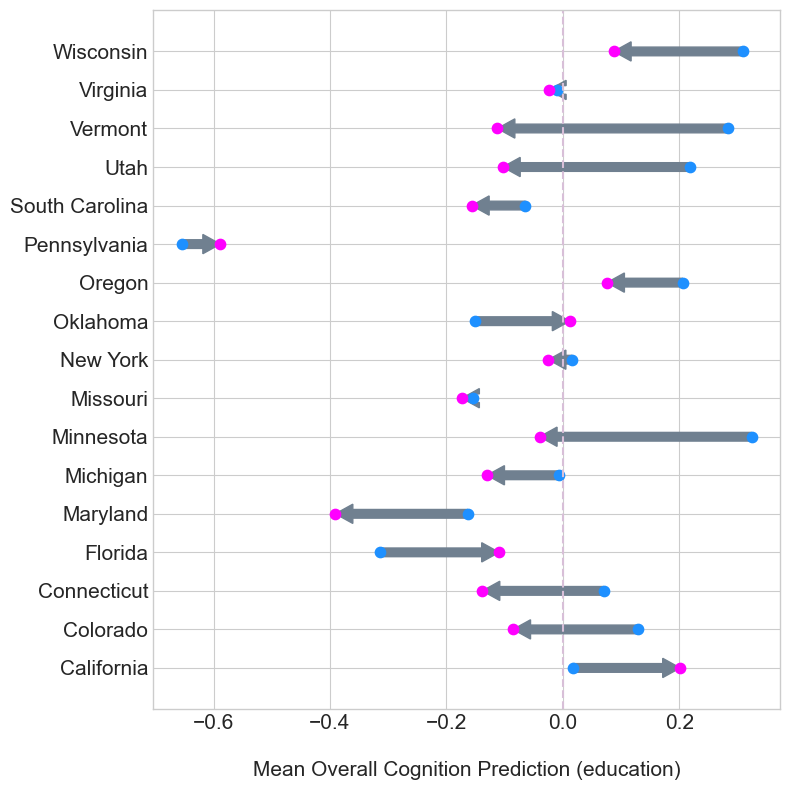

In [57]:
states = capitalized_states
quartiles_before_ps = quantiles_state   # mean prediction before poststratification
quartiles_after_ps = quantiles_state_ps  # mean prediction after poststratification

# Plotting
plt.figure(figsize=(8, 8))

# Plot arrows indicating change from before to after poststratification
for i in range(len(states)):
    plt.arrow(quartiles_before_ps[i], i, quartiles_after_ps[i] - quartiles_before_ps[i], 0, color='slategrey', width=0.225, head_width=0.5, head_length=0.03, length_includes_head=True)

# Plot second quartiles before poststratification
for i, state in enumerate(states):
    plt.scatter(quartiles_before_ps[i], i, marker='o', color='dodgerblue', label='Before PS' if i == 0 else "",s=55)  # Dot for second quartile

# Plot second quartiles after poststratification
for i, state in enumerate(states):
    plt.scatter(quartiles_after_ps[i], i, marker='o', color='fuchsia', label='After PS' if i == 0 else "",s=55)  # Dot for second quartile

# Add vertical dashed line at x = 0
plt.axvline(x=0, color='thistle', linestyle='--')

plt.yticks(range(len(states)), states,size=15)
plt.xticks(size=15)
plt.xlabel('Mean Overall Cognition Prediction (education)',size=15,labelpad=20)
#plt.title('Mean Predictions of Overall Cognition based on Education Attainment Before and After Poststratification')
plt.grid(True)
#plt.legend()
#plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1.0),frameon=True)
plt.tight_layout()
#plt.savefig('arrow_plot_edu_overall_ps_state_cognition_results_f4.svg',transparent=True,dpi=600, bbox_inches='tight',format='svg')
plt.show()

In [58]:
quantiles_per_race = np.quantile(ppc_race_mean, quantiles, axis=1)
quantiles_per_race_ps = np.quantile(ppc_race_poststrat, quantiles, axis=1)

# Convert to list of lists
quantiles_race = quantiles_per_race.flatten().tolist()
quantiles_race_ps = quantiles_per_race_ps.flatten().tolist()

quantiles_race,quantiles_race_ps

([0.34649513423995226,
  -0.37542707461662256,
  -0.17148471522369696,
  -0.00987782151270645,
  0.1522900485413465],
 [0.14592237508040926,
  -0.35900700440525846,
  -0.09629141277296925,
  0.018590707555366848,
  0.008957108298504103])

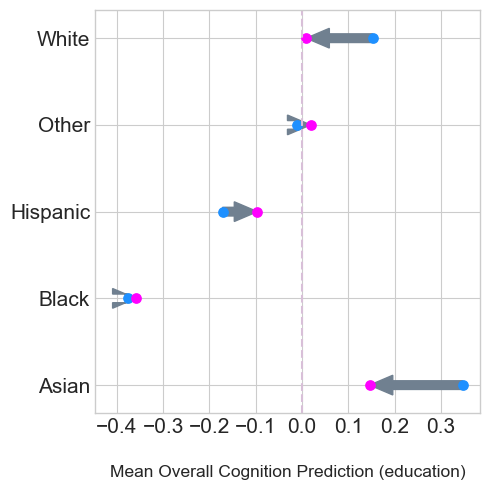

In [59]:
races = ['Asian','Black','Hispanic','Other','White']
quartiles_before_ps_r = quantiles_race   # mean prediction before poststratification
quartiles_after_ps_r = quantiles_race_ps  # mean prediction after poststratification

# Plotting
plt.figure(figsize=(5, 5))

# Plot arrows indicating change from before to after poststratification
for i in range(len(races)):
    plt.arrow(quartiles_before_ps_r[i], i, quartiles_after_ps_r[i] - quartiles_before_ps_r[i], 0, color='slategrey', width=0.10, head_width=0.227, head_length=0.05, length_includes_head=True)

# Plot second quartiles before poststratification
for i, race in enumerate(races):
    plt.scatter(quartiles_before_ps_r[i], i, marker='o', color='dodgerblue', label='Before PS' if i == 0 else "",s=45)  # Dot for second quartile

# Plot second quartiles after poststratification
for i, race in enumerate(races):
    plt.scatter(quartiles_after_ps_r[i], i, marker='o', color='fuchsia', label='After PS' if i == 0 else "",s=45)  # Dot for second quartile

# Add vertical dashed line at x = 0
plt.axvline(x=0, color='thistle', linestyle='--')

plt.yticks(range(len(races)), races,size=15)
plt.xticks(size=15)
plt.xlabel('Mean Overall Cognition Prediction (education)',size=12.5,labelpad=20)
#plt.title('Mean Predictions of Overall Cognition based on Education Attainment Before and After Poststratification')
plt.grid(True)
#plt.legend()
#plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1.0),frameon=True)
plt.tight_layout()
3plt.savefig('arrow_plot_edu_overall_ps_race_cognition_results_f4.svg',transparent=True,dpi=600, bbox_inches='tight',format='svg')
plt.show()

/var/folders/vm/f5ddqzq57cnd0dhfcyvb42440000gn/T/ipykernel_57921/723885144.py:42: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(state_values, [state_name, state_name], 'k-',color='darkseagreen', linewidth=8,zorder=1,label='before PS')  # Connect the points for the state
/var/folders/vm/f5ddqzq57cnd0dhfcyvb42440000gn/T/ipykernel_57921/723885144.py:43: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(state_values2, [state_name2, state_name2], 'k-',color='darkgoldenrod', linewidth=8,zorder=1,label='after PS')  # Connect the points for the state


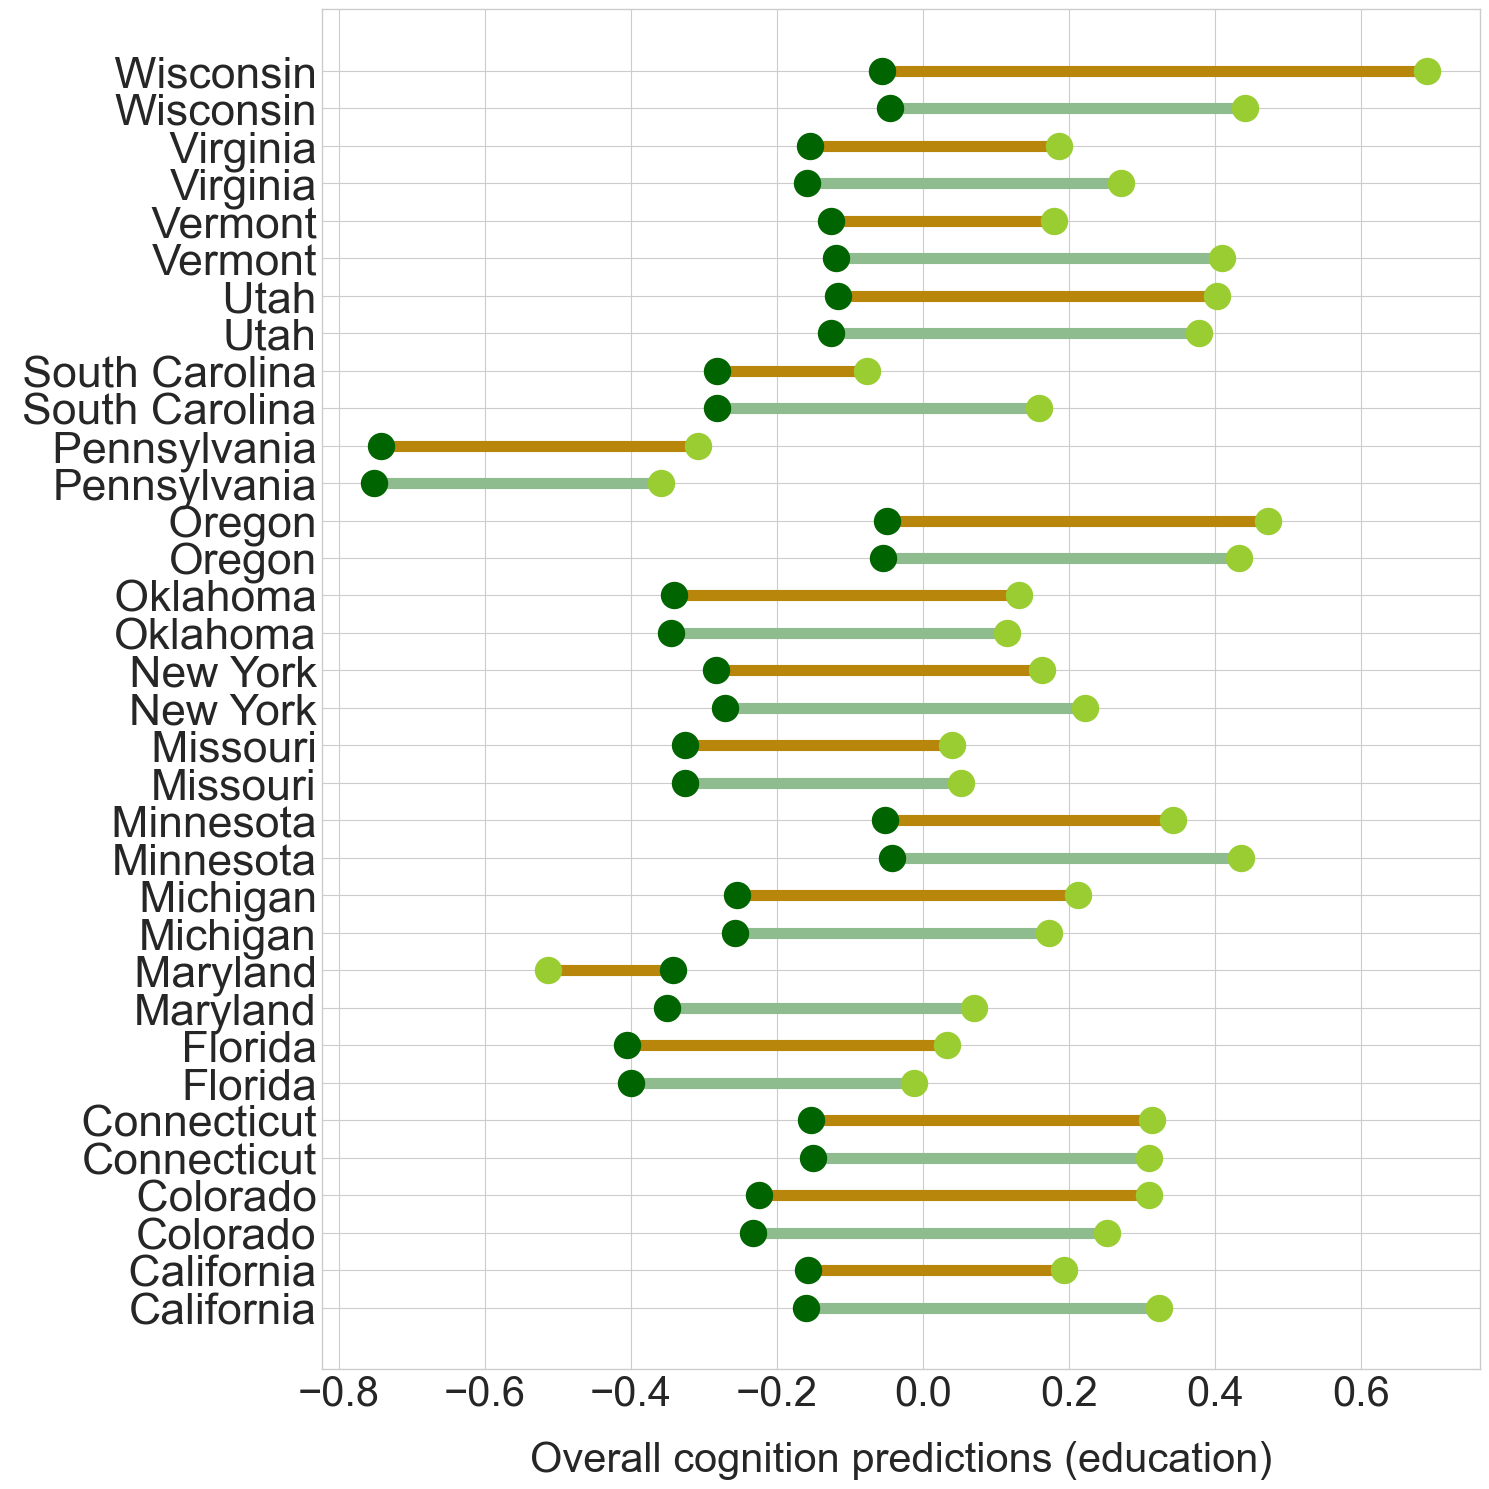

In [60]:
datas=mean_predictions_state
datas2=mean_predictions_state_ps
state_names = ['California',
 'Colorado',
 'Connecticut',
 'Florida',
 'Maryland',
 'Michigan',
 'Minnesota',
 'Missouri',
 'New York',
 'Oklahoma',
 'Oregon',
 'Pennsylvania',
 'South Carolina',
 'Utah',
 'Vermont',
 'Virginia',
 'Wisconsin']
state_names2 = [' California',
 ' Colorado',
 ' Connecticut',
 ' Florida',
 ' Maryland',
 ' Michigan',
 ' Minnesota',
 ' Missouri',
 ' New York',
 ' Oklahoma',
 ' Oregon',
 ' Pennsylvania',
 ' South Carolina',
 ' Utah',
 ' Vermont',
 ' Virginia',
 ' Wisconsin']
# Plotting
plt.figure(figsize=(15, 15))

# Transpose the data matrix to iterate over states
for state_name, state_values,state_name2, state_values2 in zip(state_names, np.array(datas).T,state_names2, np.array(datas2).T):
    plt.plot(state_values, [state_name, state_name], 'k-',color='darkseagreen', linewidth=8,zorder=1,label='before PS')  # Connect the points for the state
    plt.plot(state_values2, [state_name2, state_name2], 'k-',color='darkgoldenrod', linewidth=8,zorder=1,label='after PS')  # Connect the points for the state
    
    plt.scatter(state_values[0], state_name, color='darkgreen', label='low edu', s=350,zorder=2)  # Plot value 1 for the state
    plt.scatter(state_values[1], state_name, color='yellowgreen', label='high edu', s=350,zorder=2)  # Plot value 2 for the state
    
    plt.scatter(state_values2[0], state_name2, color='darkgreen', s=350,zorder=2)  # Plot value 1 for the state
    plt.scatter(state_values2[1], state_name2, color='yellowgreen', s=350,zorder=2)  # Plot value 2 for the state
    
plt.xticks(size=30)
plt.yticks(size=32)
plt.xlabel('Overall cognition predictions (education)',size= 30,labelpad=20)
#plt.ylabel('States',size=25)
#plt.title('Values for Each State')
#plt.legend(['before PS','after PS','low edu', 'high edu'],loc='upper right', bbox_to_anchor=(1.5, 1.0),frameon=True)
plt.grid(True)
plt.tight_layout()
#plt.savefig('lolli_plot_edu_overall_ps_state_cognition_results_f5.svg',transparent=True,dpi=600, bbox_inches='tight',format='svg')
plt.show()


/var/folders/vm/f5ddqzq57cnd0dhfcyvb42440000gn/T/ipykernel_57921/4254913528.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(race_values, [race_name, race_name], 'k-',color='darkseagreen', linewidth=8,zorder=1,label='before PS')  # Connect the points for the state
/var/folders/vm/f5ddqzq57cnd0dhfcyvb42440000gn/T/ipykernel_57921/4254913528.py:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(race_values2, [race_name2, race_name2], 'k-',color='darkgoldenrod', linewidth=8,zorder=1,label='after PS')  # Connect the points for the state


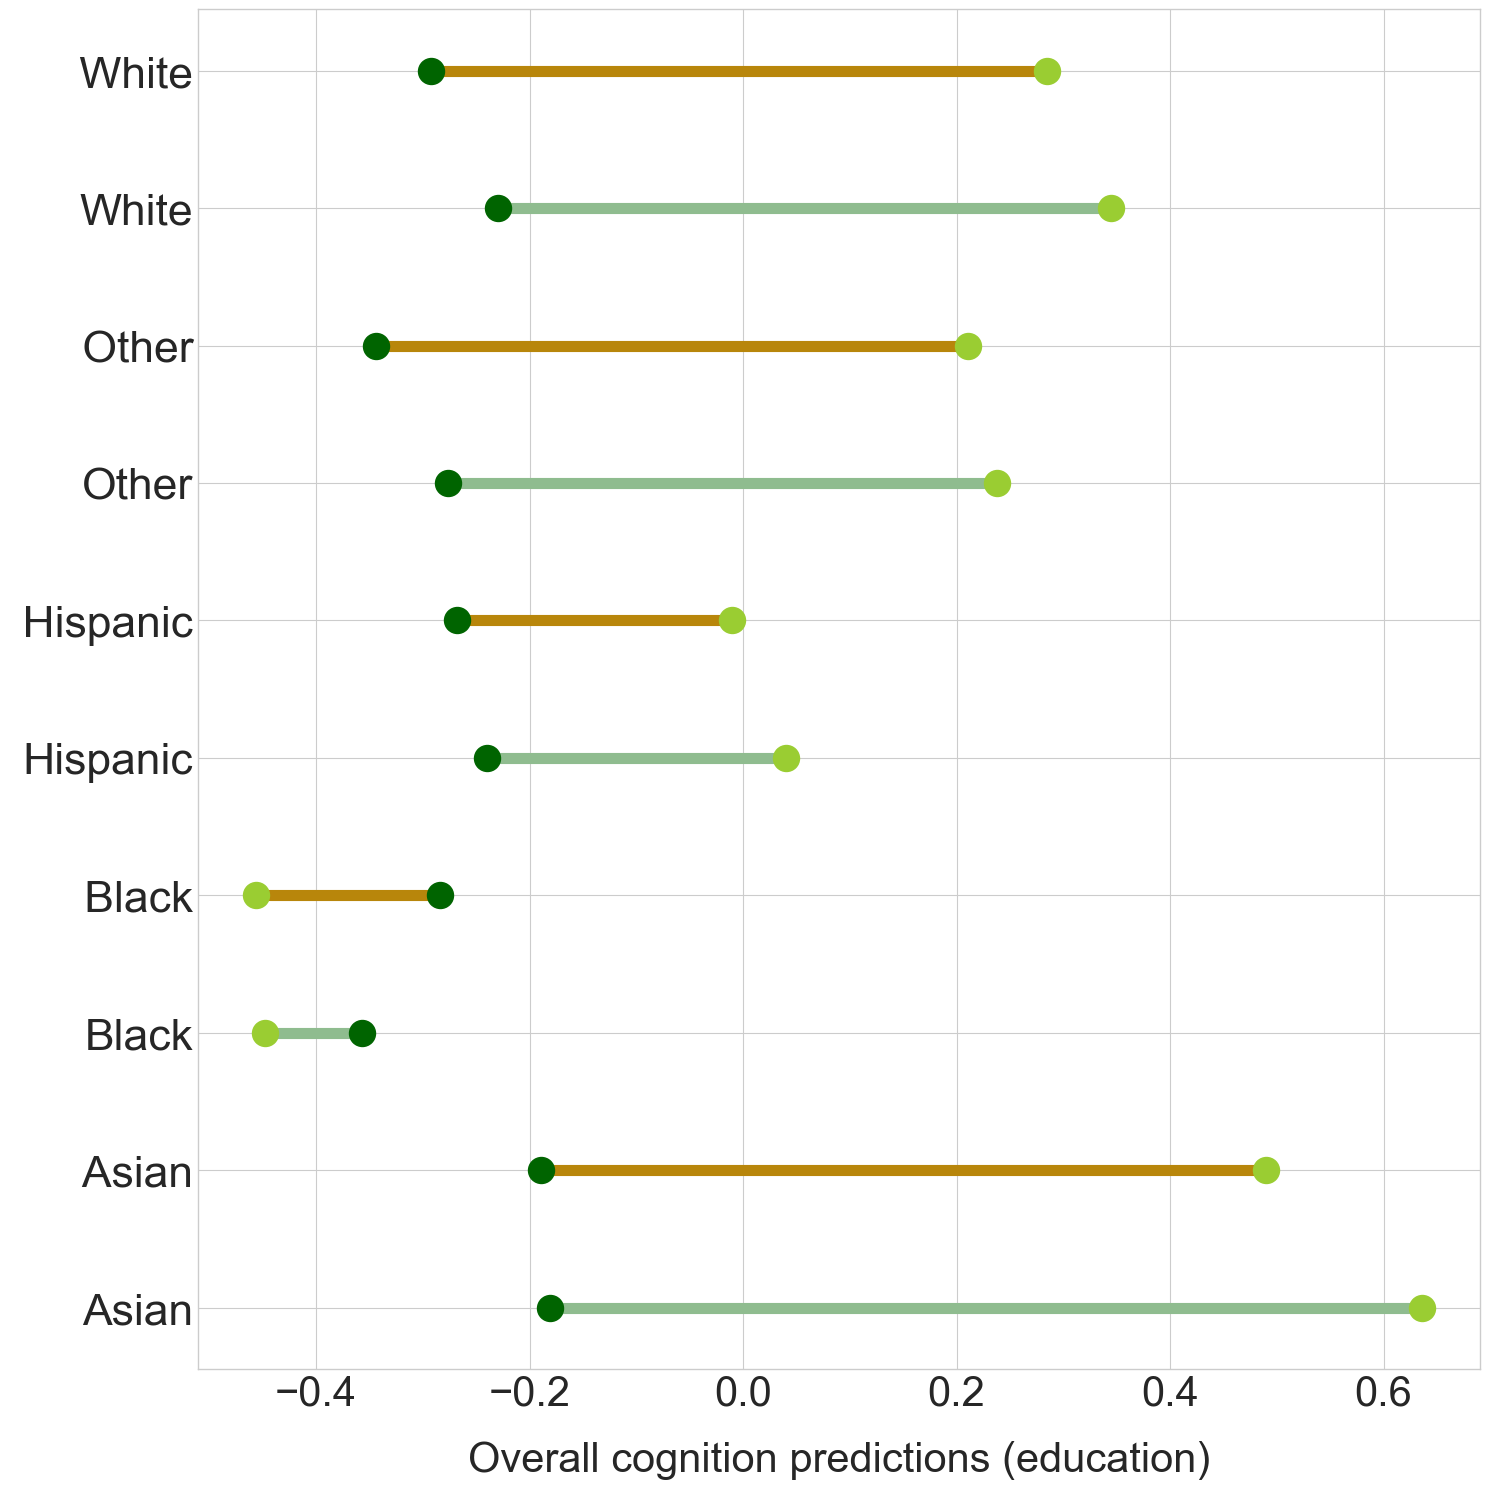

In [61]:
datas_r=mean_predictions_race
datas_r2=mean_predictions_race_ps
race_names = ['Asian',
 'Black',
 'Hispanic',
 'Other',
 'White']
#dont forget the blank space in front of the name so not overwritten
race_names2 = [' Asian',
 ' Black',
 ' Hispanic',
 ' Other',
 ' White']
# Plotting
plt.figure(figsize=(15, 15))

# Transpose the data matrix to iterate over states
for race_name, race_values,race_name2, race_values2 in zip(race_names, np.array(datas_r).T,race_names2, np.array(datas_r2).T):
    plt.plot(race_values, [race_name, race_name], 'k-',color='darkseagreen', linewidth=8,zorder=1,label='before PS')  # Connect the points for the state
    plt.plot(race_values2, [race_name2, race_name2], 'k-',color='darkgoldenrod', linewidth=8,zorder=1,label='after PS')  # Connect the points for the state
    
    plt.scatter(race_values[0], race_name, color='darkgreen', label='low edu', s=350,zorder=2)  # Plot value 1 for the state
    plt.scatter(race_values[1], race_name, color='yellowgreen', label='high edu', s=350,zorder=2)  # Plot value 2 for the state
    
    plt.scatter(race_values2[0], race_name2, color='darkgreen', s=350,zorder=2)  # Plot value 1 for the state
    plt.scatter(race_values2[1], race_name2, color='yellowgreen', s=350,zorder=2)  # Plot value 2 for the state
    
plt.xticks(size=30)
plt.yticks(size=32)
plt.xlabel('Overall cognition predictions (education)',size= 30,labelpad=20)
#plt.ylabel('States',size=25)
#plt.title('Values for Each Race')
#plt.legend(['before PS','after PS','low edu', 'high edu'],loc='upper right', bbox_to_anchor=(1.5, 1.0),frameon=True)
plt.grid(True)
plt.tight_layout()
#plt.savefig('lolli_plot_edu_overall_ps_race_cognition_results_f5.svg',transparent=True,dpi=600, bbox_inches='tight',format='svg')
plt.show()